In [1]:
segmentation_checkpoint="axial_segmentation_effseg_132508-epoch-100.pth"
axial_det_checkpoint="axial_detection_effdet_134352-epoch-52.pth"

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import sys

import pydicom
import pylibjpeg

effdet_path = "../third/effdet"
sys.path.append(effdet_path)
from effdet import create_model

timm_path = "../third/timm-pytorch-image-models"
sys.path.append(timm_path)
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from matplotlib import patches
import sklearn
import os
from tqdm import tqdm

omega_path = "../third/omegaconf"
sys.path.append(omega_path)
from omegaconf import OmegaConf
import glob
import sklearn
import math
import random
import numpy as np
import time

from PIL import Image

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as T
import torchvision.transforms.functional as TF
# from transformers import get_cosine_schedule_with_warmup

import warnings

warnings.filterwarnings('ignore')
from sklearn import metrics, model_selection, preprocessing

# from sklearn.model_selection import GroupKFold


# pos_weight = torch.tensor(pos_weight)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')

In [4]:
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
test_df

,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


## read dcm file


In [5]:
def rescale_img_to_hu(dcm_ds):
    """Rescales the image to Hounsfield unit.
    """
    return dcm_ds.pixel_array * dcm_ds.RescaleSlope + dcm_ds.RescaleIntercept


def read_dcm(patient_dir, num_instance):
    dcm_path = os.path.join(patient_dir, f"{int(num_instance)}.dcm")
    ds = pydicom.dcmread(dcm_path)
    img2d = rescale_img_to_hu(ds)
    return normalize_hu(img2d)

def read_patient_dcm(patient_dir):
    """
    여기서 이미지를 정상적인 순서로 돌려 놓는다
    :param patient_dir:
    :return:
    """
    num_slices = len(glob.glob(patient_dir + "/*.dcm"))
    # print(f"total slices {num_slices}")
    imgs = np.zeros((num_slices, 512, 512))
    image_positions = np.zeros((num_slices, 3))
    image_orientations = np.zeros((num_slices, 6))
    pixel_spacings = np.zeros((num_slices, 2))
    slice_thicknesses = np.zeros((num_slices, 1))

    ignore_count = 1
    for i in range(num_slices):
        dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        while os.path.exists(dcm_path) == False:
            ignore_count += 1
            dcm_path = os.path.join(patient_dir, f"{i+ignore_count}.dcm")
        ds = pydicom.dcmread(dcm_path)

        image_positions[i, :] = ds.ImagePositionPatient
        image_orientations[i, :] = ds.ImageOrientationPatient
        pixel_spacings[i, :] = ds.PixelSpacing
        slice_thicknesses[i, :] = ds.SliceThickness

        img2d = rescale_img_to_hu(ds)

        imgs[i] = img2d

    is_flip = False
    # check z is in good direction
    if image_positions[0, 2] < image_positions[1, 2]:
        is_flip = True
        # flip image in z direction
        imgs = np.flip(imgs, axis=0)
        image_positions = np.flip(image_positions, axis=0)
        pixel_spacings = np.flip(pixel_spacings, axis=0)
        slice_thicknesses = np.flip(slice_thicknesses, axis=0)

    aspect = calculate_aspect(image_positions, pixel_spacings)
        
    return imgs, aspect, pixel_spacings[0, 0]


def normalize_hu(data):
    # normalize to 0-1
    # return (data - data.min()) / data.max()
    data = np.clip(data, a_min=-2242, a_max=2242) / 4484 + 0.5
    return data

def calculate_aspect(image_positions, pixel_spacings):
    """
    calculate z aspect, z 를 몇배로 늘여야 하는가야
    :param image_positions:
    :param pixel_spacings:
    :return:
    """
    height = image_positions[0, 2] - image_positions[1, 2]
    pixel_spacing = pixel_spacings[0, 0]
    aspect = height / pixel_spacing
    return aspect

In [6]:
from efficientunet import *
def get_axial_segmentation_model(checkpoint):
    model = get_efficientunet_b5(out_channels=2, concat_input=True, pretrained=True)
    
    state = torch.load(os.path.join(DATA_DIR, 'checkpoint', checkpoint))
    model.load_state_dict(state["model"])
    model.eval()
    return model.to(device)
    
seg_model = get_axial_segmentation_model(segmentation_checkpoint)

In [7]:
from effdet import create_model

def get_axial_detection_model(checkpoint, image_size=512):
    model = create_model('efficientdetv2_ds' , bench_task='predict' , num_classes=1 , image_size=(image_size, image_size), pretrained=True, max_det_per_image=1)

    state = torch.load(os.path.join(DATA_DIR, 'checkpoint',checkpoint))
    model.load_state_dict(state["model"])
    model.eval()
    return model.to(device)

det_model = get_axial_detection_model(axial_det_checkpoint)

In [8]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).sort_values('StudyInstanceUID')
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
1837,1.2.826.0.1.3680043.10001,0,0,0,0,0,0,0,0
823,1.2.826.0.1.3680043.10005,0,0,0,0,0,0,0,0
1021,1.2.826.0.1.3680043.10014,0,0,0,0,0,0,0,0
667,1.2.826.0.1.3680043.10016,1,0,1,0,0,0,0,0
322,1.2.826.0.1.3680043.10032,0,0,0,0,0,0,0,0


In [9]:
# index = 398
# UID = train_df.iloc[index]['StudyInstanceUID']
# print(UID)
# label = train_df.iloc[index][['patient_overall', 'C1','C2','C3','C4','C5','C6','C7']].values
# print(label)
# imgs, aspect, pixel_spacing = read_patient_dcm(os.path.join(IMAGES_DIR, UID))
# print(imgs.shape)
# print(aspect)
# print(pixel_spacing)

In [10]:
# cliped_imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5
# imgs_tensor = torch.tensor(cliped_imgs, dtype=torch.float)
# imgs_tensor = (imgs_tensor - 0.5) * 2.
# print(imgs_tensor.shape)
# print(imgs_tensor.min(), imgs_tensor.max())

In [11]:
# plt.imshow(imgs_tensor[100, :, :])

## get boundary

In [12]:
def get_axial_boundary_from_segmentation(seg, pixel_spacing, throw=100, tol=0.2, max_mm=100):
    """
    seg : H x W
    """
    image_size = seg.shape[0]
    min_size = min(image_size, max_mm / pixel_spacing)
    
    rows, columns = seg.nonzero(as_tuple=True)
    rows.sort()
    columns.sort()
    
    throw = min(len(rows) // 2, throw)
    
    if(len(rows)) == 0:
        return torch.tensor([0, 0, image_size, image_size]).to(device)
    
    xmin, xmax = columns[throw], columns[-throw]
    ymin, ymax = rows[throw], rows[-throw]
    
    w = (xmax - xmin) * (1 + tol)
    h = (ymax - ymax) * (1 + tol)
    new_size = max(w, h, min_size)
    new_size = min(image_size, new_size)
    
    xcenter, ycenter = (xmax + xmin) / 2, (ymax + ymin) / 2
    
    xmin = torch.min(torch.tensor(image_size - new_size), xcenter - new_size / 2)
    xmin = xmin.clip(min=0)
    
    ymin = torch.min(torch.tensor(image_size - new_size), ycenter - new_size / 2)
    ymin = ymin.clip(min=0)
    
    return torch.stack([xmin, ymin, xmin + new_size, ymin + new_size])

In [13]:
@torch.no_grad()
def predict_seg(x, model):
    """
    return: N x 1 x H x W
    """
    x = x.to(device)
    logits = model(x)

    classification_score, mse_score = logits.sigmoid().chunk(2, dim=1)
    classification_pred = classification_score.gt(0.5).float()
    pred = (classification_pred * mse_score)
    
    return pred, classification_pred.mean(dim=(1, 2, 3))

In [14]:
@torch.no_grad()
def seg_patient(imgs_tensor, model, batch_size=64, area_threshold=0.01):
    
    seg_result = []
    areas = []
    for i in range(math.ceil(imgs_tensor.shape[0] / batch_size)):
        batch_tensor = imgs_tensor[i * batch_size : i * batch_size + batch_size]
        batch_tensor = torch.stack((batch_tensor, batch_tensor, batch_tensor), axis=1)
        batch_tensor = TF.resize(batch_tensor, (256, 256))
        # print(batch_tensor.shape)
        
        seg, area = predict_seg(batch_tensor, model)
        seg_result.append(seg)
        areas.append(area)
    
    
    return torch.cat(seg_result, axis=0), torch.cat(areas, axis=0)

# seg_result = seg_patient(imgs_tensor, seg_model)
# print(seg_result.shape)
# plt.imshow(seg_result[seg_result.shape[0] // 2, 0, :, :])

In [15]:
def get_axial_boundary(segs, pixel_spacing, img_size=256):
    boundary_list = []
    for i in range(segs.shape[0]):
        seg = segs[i, 0, :, :]
        # print(seg.shape)
        boundary = get_axial_boundary_from_segmentation(seg, pixel_spacing, throw=50, tol=0.2, max_mm=50)
#         print(boundary)
        boundary_list.append(boundary)
    boundary_list = torch.stack(boundary_list, axis=0) * (512. / img_size)
    return boundary_list

# axial_boundary = get_axial_boundary(seg_result)
# print(axial_boundary.shape)

# print(axial_boundary[axial_boundary.shape[0] // 2, :])

# boundary = axial_boundary[axial_boundary.shape[0] // 2, :] / 2
# plt.imshow(seg_result[seg_result.shape[0] // 2, 0, :, :])
# plt.axvline(boundary[0])
# plt.axvline(boundary[2])
# plt.axhline(boundary[1])
# plt.axhline(boundary[3])

### Detection

In [28]:
@torch.no_grad()
def predict_det(x, model):
    x = x.to(device)
    bboxes = model(x) # N x 1 x 6
    
    return bboxes[:, 0, :]
    
    
def crop_resize_images(imgs_tensor, boundary_list, img_size=512):
    croped_list = []
    for i in range(imgs_tensor.shape[0]):
        xmin, ymin, xmax, ymax = boundary_list[i, :]
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        # print(xmin, ymin, xmax, ymax)
        croped = TF.crop(imgs_tensor[i, :, :, :], top=ymin, left=xmin, height=ymax-ymin, width=xmax-xmin)
        croped = TF.resize(croped, (img_size, img_size))
        croped_list.append(croped)
        
    return torch.stack(croped_list, 0)

def get_original_bbox(bbox, boundary):
    scale = 512. / (boundary[:, [2]] - boundary[:, [0]])
    
    org_bbox = bbox / scale
    org_bbox[:, 0] += boundary[:, 0]
    org_bbox[:, 1] += boundary[:, 1]
    org_bbox[:, 2] += boundary[:, 0]
    org_bbox[:, 3] += boundary[:, 1]
    
    return org_bbox

def check_detection_result(det_result, img_size=512., threshold=0.2):
    # throw big bboxes
    areas = (det_result[:, 2] - det_result[:, 0]) * (det_result[:, 3] - det_result[:, 1]) / (img_size * img_size)
    # print(areas)
    big_indices = torch.argwhere(areas > threshold)
    det_result[big_indices, 4] = 0.
    return det_result

@torch.no_grad()
def det_patient(imgs_tensor, model, boundary, batch_size=8):
    det_result = []
    
    imgs_tensor = torch.stack((imgs_tensor[0:-2, :, :], imgs_tensor[1:-1, :, :], imgs_tensor[2:, :, :]), axis=1)
   
    boundary = boundary[1:-1, :]
  
    imgs_tensor = crop_resize_images(imgs_tensor, boundary)
    
    # print(imgs_tensor.shape)
    for i in range(math.ceil(imgs_tensor.shape[0] / batch_size)):
        batch_tensor = imgs_tensor[i * batch_size : i * batch_size + batch_size]
        
        pred = predict_det(batch_tensor, model)
        det_result.append(pred)
    
    # det_result.append(torch.tensor([0,0,0,0,0,0]))
    det_result = torch.cat(det_result, axis=0)
    # det_result = check_detection_result(det_result, threshold=0.1)
    bboxes, scores = get_original_bbox(det_result[:, :4], boundary), det_result[:, 4]
    
    return bboxes, scores

# bboxes, scores = det_patient(imgs_tensor, det_model, axial_boundary)
# print(bboxes.shape)
# plt.plot(scores)

In [17]:
# max_score_index = scores.argmax()
# print(max_score_index)
# print(scores.shape)
# print(imgs_tensor.shape)
# plt.imshow(imgs_tensor[max_score_index+1, :, :])
# plt.axvline(bboxes[max_score_index+1, 0])
# plt.axvline(bboxes[max_score_index+1, 2])
# plt.axhline(bboxes[max_score_index+1, 1])
# plt.axhline(bboxes[max_score_index+1, 3])

In [18]:
# plt.imshow(seg_result[max_score_index + 1, 0, :, :])

### get bbox class

In [29]:
def get_bbox_class(seg, bbox):
    """
    label 은 0.125 의 단위로, 
    seg: H x W
    bbox: [xmin, ymin, xmax, ymax]
    """
    xmin, ymin, xmax, ymax = bbox.int()
    area = seg[ymin:ymax, xmin:xmax]
    
    # print(area)
    result = torch.mean(area[area>0])
    result = torch.round(result / 0.125)
    
    return result

# seg_list = seg_result[1:-1, 0, :, :]
# seg_bboxes = bboxes / 2
# check_index=362
# get_bbox_class(seg_list[check_index, :, :], seg_bboxes[check_index, :])


In [30]:
def get_bbox_class_list(seg_list, seg_bboxes):
    class_list = []
    for i in range(seg_list.shape[0]):
        class_index = get_bbox_class(seg_list[i, :, :], seg_bboxes[i, :])
        class_list.append(class_index)
        
    return torch.stack(class_list)

# class_list = get_bbox_class_list(seg_result[1:-1, 0, :, :], bboxes / 2)
# print(class_list.shape)
# print(f"max {class_list[max_score_index]}")
# plt.plot(class_list)

In [31]:
def cal_loss(prob, label):
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [32]:
def get_prob(scores, class_list, eps=1e-2):
    """
    scores: N x 5
    class_list: N x 5
    """
    scores = scores.reshape(-1)
    class_list = class_list.reshape(-1)
    
    prob = np.zeros(8) + eps
    # prob[0] = scores.max()
    
    for i in range(len(scores)):
        score = scores[i]
        
        if torch.isnan(class_list[i]):
            continue
        
        class_index = int(class_list[i])
        prob[class_index] = min(1-eps, max(prob[class_index], score))
    
    prob[0] = prob.max()
    
    return prob

# prob = get_prob(scores, class_list)
# print(prob)

In [66]:
a = torch.randn((4, 5))
a[2, :] = 0
a.count_nonzero()


tensor(15)

In [70]:
@torch.no_grad()
def infer_patient(UID, return_prob=True, plot=False):
    imgs, aspect, pixel_spacing = read_patient_dcm(os.path.join(IMAGES_DIR, UID))

    imgs = np.clip(imgs, a_min=-2242, a_max=2242) / 4484 + 0.5
    imgs_tensor = torch.tensor(imgs, dtype=torch.float)
    
    del imgs
    
    imgs_tensor = (imgs_tensor - 0.5) * 2.
    
    seg_result, area_result = seg_patient(imgs_tensor, seg_model)

    area_threshold = 1e-3
    valid_slices = torch.argwhere(area_result > area_threshold)
    slice_start = valid_slices[0]
    slice_end = valid_slices[-1]

    
    seg_result=seg_result[slice_start:slice_end+1, :, :, :]
    
    axial_boundary = get_axial_boundary(seg_result, pixel_spacing)
    

    imgs_tensor = imgs_tensor[slice_start:slice_end+1, :, :]
    bboxes, scores = det_patient(imgs_tensor, det_model, axial_boundary)
    
    if plot is True:
        print(imgs_tensor.shape, bboxes.shape, scores.shape, seg_result.shape)
        
        max_slice = scores.argmax()
        max_bbox = bboxes[max_slice].cpu()
        print("max slice", max_slice)
        print(max_bbox)
        _, axs = plt.subplots(1, 2, figsize=(24, 12))
        
        axs[0].imshow(imgs_tensor[max_slice, :, :].cpu())
        axs[0].axvline(max_bbox[0])
        axs[0].axvline(max_bbox[2])
        axs[0].axhline(max_bbox[1])
        axs[0].axhline(max_bbox[3])
        
        max_seg = seg_result[max_slice, 0, :, :]
        max_seg = torch.round(max_seg / 0.125)
        
        # max_seg 에서 비례
        max_bbox = max_bbox / 2
        bbox_seg = max_seg[max_bbox[1].int():max_bbox[3].int(), max_bbox[0].int():max_bbox[2].int()]
        print("bbox class", bbox_seg[bbox_seg>0].mean())
        
        bbox_area = (max_bbox[3] - max_bbox[1]) * (max_bbox[2] - max_bbox[0])
        area_portion =  bbox_area / 256. / 256.
        print("area", area_portion)
        
        print(bbox_seg.shape)
        # axs[1].imshow(bbox_seg.cpu(), cmap='nipy_spectral')
        print("seg_area" ,bbox_seg.count_nonzero() / bbox_area)
        
        axs[1].imshow(max_seg.cpu(), cmap='nipy_spectral')
    
    class_list = get_bbox_class_list(seg_result[1:-1, 0, :, :], bboxes / 2)
    prob = get_prob(scores, class_list)
    
    if return_prob:
        return prob
    else:
        return {
            f'{UID}_patient_overall': prob[0],
            f'{UID}_C1': prob[1],
            f'{UID}_C2': prob[2],
            f'{UID}_C3': prob[3],
            f'{UID}_C4': prob[4],
            f'{UID}_C5': prob[5],
            f'{UID}_C6': prob[6],
            f'{UID}_C7': prob[7]
        }

1.2.826.0.1.3680043.19688
torch.Size([272, 512, 512]) torch.Size([270, 4]) torch.Size([270]) torch.Size([272, 1, 256, 256])
max slice tensor(217, device='cuda:0')
tensor([290.8019, 232.4744, 355.3801, 288.7852], dtype=torch.float64)
bbox class tensor(5.9712, device='cuda:0')
area tensor(0.0139, dtype=torch.float64)
torch.Size([28, 32])
seg_area tensor(0.4576, device='cuda:0', dtype=torch.float64)
time 8.117449522018433
[0.9476884  0.0519693  0.034708   0.02031977 0.03321615 0.0201622
 0.9476884  0.11634777]
[0 0 0 0 0 0 0 0]


1.7065256812754495

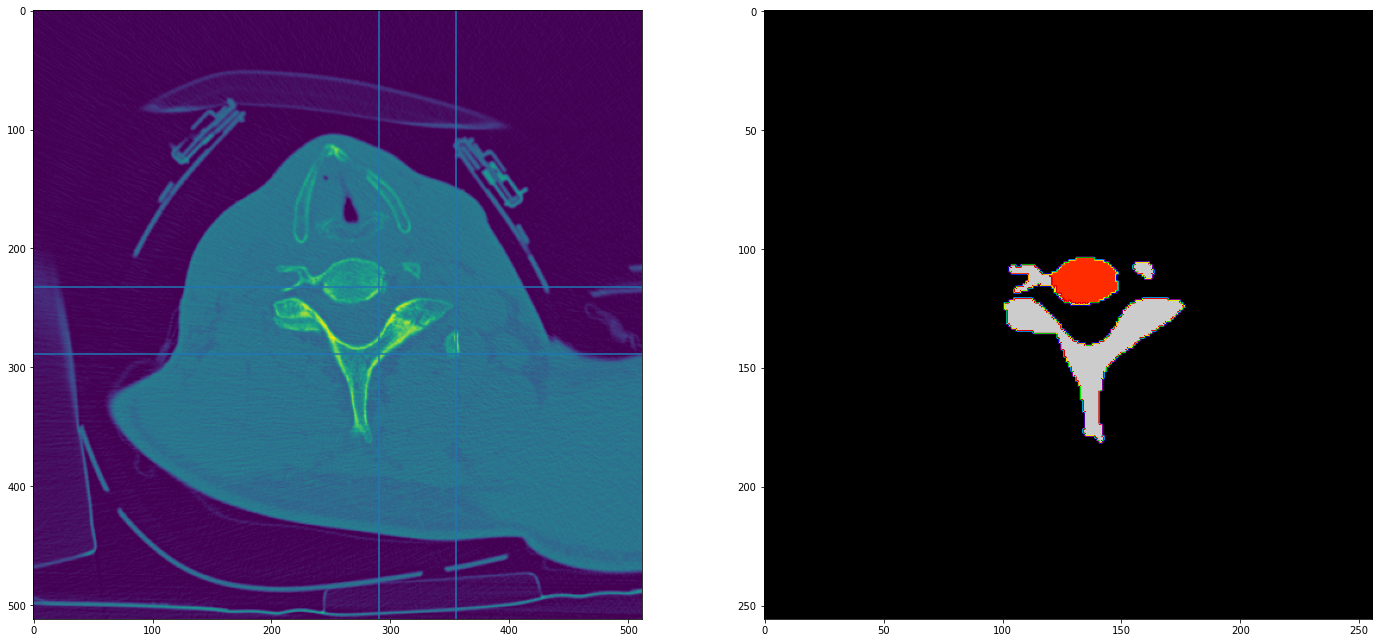

In [82]:

index = 646
UID = train_df.iloc[index]['StudyInstanceUID']
print(UID)
label = train_df.iloc[index][['patient_overall', 'C1','C2','C3','C4','C5','C6','C7']].values

start_time = time.time()

prob = infer_patient(UID, plot=True)


end_time = time.time()

print("time" , end_time - start_time)

print(prob)
print(label)


loss = cal_loss(prob, label)
loss

In [25]:
# losses = []
# for index in tqdm(range(600, 630)):

#     UID = train_df.iloc[index]['StudyInstanceUID']
#     # print(UID)
#     label = train_df.iloc[index][['patient_overall', 'C1','C2','C3','C4','C5','C6','C7']].values
    
#     prob = infer_patient(UID)
#     loss = cal_loss(prob, label)
#     print(prob)
#     print(label)
#     print(f'{index} {UID} loss {loss}')
#     losses.append(loss)
    
# print(np.mean(losses))
    

In [26]:
losses

NameError: name 'losses' is not defined